# 关注公众号【Python读财】，选择“星标”公众号，重磅干货，第一时间送达

![](https://upload-images.jianshu.io/upload_images/8316927-0fb816f497f6e7f5.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

基金定投是近几年各种理财平台比较推崇的一种理财方式，大多数关于定投的宣传语中，会有这”六字箴言“：不择时，长期投。所谓择时，便是选择合适的买点和卖点，那基金定投真的用不着择时么？本文就用数据来探究一下是否需要择时以及该如何进行择时。

# 导包

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tushare as ts
import warnings
from IPython.display import display
from tqdm import tqdm_notebook
from datetime import *
warnings.filterwarnings("ignore")
%matplotlib inline

pro = ts.pro_api()
plt.rcParams["font.sans-serif"] = ["FangSong"]

# 上证与道琼斯指数的对比

In [254]:
sz_index = ts.pro_bar(ts_code="000001.SH",start_date="20040101",end_date="20200101",adj="qfq",asset="I")[["trade_date","close"]]
sz_index["trade_date"] = pd.to_datetime(sz_index["trade_date"])
sz_index.set_index("trade_date",inplace=True)
sz_index.sort_index(inplace=True)
dj_index = pro.index_global(ts_code='DJI', start_date='20040101', end_date='20200101')[["trade_date","close"]]
dj_index["trade_date"] = pd.to_datetime(dj_index["trade_date"])
dj_index.set_index("trade_date",inplace=True)
dj_index.sort_index(inplace=True)

Text(0, 0.5, '道琼斯指数点位')

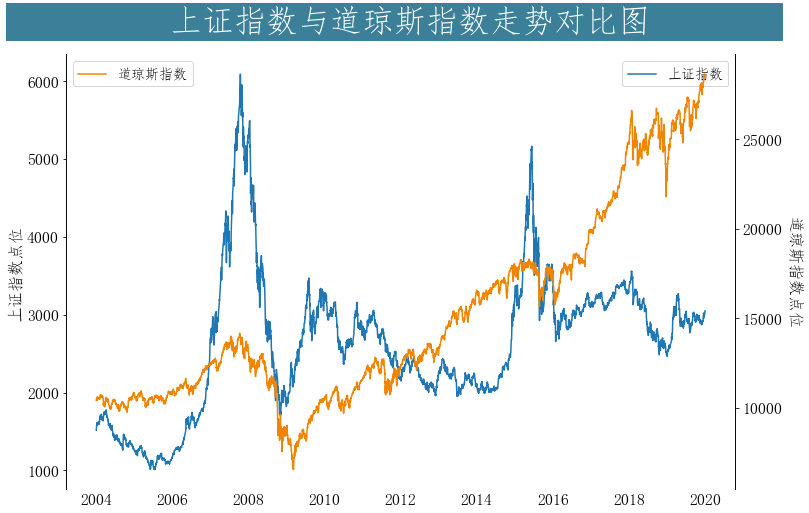

In [255]:
fig,ax1 = plt.subplots(figsize=(12,8))
fig.text(x=0.06, y=0.92, s='          上证指数与道琼斯指数走势对比图        ', fontsize=32, 
                 weight='bold', color='white', backgroundcolor='#3c7f99')
ax1.plot(sz_index.index,sz_index.values,label="上证指数")
ax1.tick_params(axis='x',length=0)
ax1.tick_params(axis='both',labelsize=16)
ax1.legend(fontsize=14,loc=0)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_ylabel("上证指数点位",fontdict={"size":16})

ax2 = ax1.twinx()
ax2.plot(dj_index.index,dj_index.values,label="道琼斯指数",color="#f28500")
ax2.tick_params(axis='x',length=0)
ax2.tick_params(axis='both',labelsize=16)
ax2.legend(fontsize=14,loc=0)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.set_ylabel("道琼斯指数点位",fontdict={"size":16,'rotation':270},labelpad=20)

上面的这张图是2004年到2020年16年间，上证指数和道琼斯指数的走势对比图，大致代表了两个不同资本市场的行情走势。

从图中可以看出两大指数的走势都颇具特点，道指基本是一种长牛的走势，对于这种走势，如果进行指数基金定投是可以不择时的。

而对上证指数而言，走势呈现一种比较明显的周期性，牛短熊长，一个牛熊周期大概为7.5年，整体的重心是向上移动的。如果进行长期投资但不进行择时，虽然长周期来看也可以获得正向的收益，但却享受不了牛市带来的情绪溢价，就像坐了趟过山车，图个刺激。

![](https://upload-images.jianshu.io/upload_images/8316927-d829b6c97f50d3f9.gif?imageMogr2/auto-orient/strip)

所以，对基金定投而言，还是有必要进行择时操作的，在指数低估时买入，等牛市来时卖出，那么该如何进行择时呢？

# 择时的基本策略

定投中可以根据股指的点位或估值高低等指标进行择时操作，本文主要研究基于估值的择时操作，在估值较低时开始定投，待估值达到历史较高水平时卖出，因此如何定义估值是高还是低便是择时操作的关键。

由于沪深300指数能够较好地反映沪深两市的走势，常被设为基金业绩的比较基准。所以本文其为例进行研究，并以市盈率（PE）为估值指标，探究**不同估值区间的择时效果**。

具体策略：择时的指标为该指数当前的PE估值在过去7年（兼顾一轮牛熊周期）的**分位数水平**，若分位数水平低于定义的区间下限，开启定投周期，直到估值的分位数水平高于区间上限，将持有的份额全部卖出。卖出后，要等到估值水平再次低于区间下限，开始下一轮定投，按照这个规则持续运行。

回测的具体参数如下：

投资标的：易方达沪深 300ETF联接A（110020.OF）

回测时间范围：2013年1月1日-2020年1月1日

申购费率：0.15%

赎回费率：0.5%

估值区间：20%-80，30%-80%，40%-80%，20%-70%，30%-70%，40%-70%

每次定投金额：5000

频率：每周一

# 完整代码框架

In [282]:
def run_strategy(index_code="",fund_code="",money_per_time=5000,
                 start_date=None,end_date=None,v_low = None,
                 v_high = None,plot=True):

    fund_df = pro.fund_nav(ts_code = fund_code)
    fund_df = fund_df.loc[fund_df.update_flag=='0',['ts_code','end_date','unit_nav']].rename(columns = {'end_date':'trade_date'})
    fund_df = fund_df[(fund_df.trade_date>=start_date) & (fund_df.trade_date<=end_date)]
    fund_df["trade_date"] = pd.to_datetime(fund_df.trade_date)
    fund_df.sort_values(by="trade_date",inplace=True)
    fund_df.reset_index(drop=True,inplace=True)

    # tushare提取数据有限制
    # 分开提取然后合并数据
    index_start_date = str(int(start_date[:4])-7) + start_date[4:]
    index_end_date = end_date
    index_valuation_1 = pro.index_dailybasic(ts_code = "000300.SH",start_date = index_start_date,end_date = start_date,fields="trade_date,pe_ttm")
    index_valuation_2 = pro.index_dailybasic(ts_code = "000300.SH",start_date = start_date,end_date = index_end_date,fields="trade_date,pe_ttm")
    index_valuation = pd.concat([index_valuation_1,index_valuation_2],axis=0)
    index_valuation["trade_date"] = pd.to_datetime(index_valuation.trade_date)
    index_valuation.sort_values(by="trade_date",inplace=True)
    index_valuation.set_index("trade_date",inplace=True)



    # 回测时需要计算的指标
    fund_df["units"] = np.nan
    fund_df["total_units"] = np.nan
    fund_df["market_value"] = np.nan
    fund_df["signal"] = np.nan
    fund_df["avg_unit_cost"] = np.nan
    fund_df["return_rate"] = np.nan
    fund_df["round"] = np.nan
    fund_df["percentile"] = np.nan
    round_num = 0
    round_on = False

  #  money_per_time = 5000

    # 循环进行回测
    # 申购费率设置为0.15%
    # 赎回费率设置为0.5%
    for i in tqdm_notebook(range(len(fund_df))):
        valuation_start_date = (fund_df.loc[i,"trade_date"]-pd.Timedelta(7,unit="y")).date()
        valuation_end_date = fund_df.loc[i,"trade_date"]
        valuation_data = index_valuation.loc[valuation_start_date:valuation_end_date].iloc[:,0].values.tolist()

        valuation_high = np.percentile(valuation_data,v_high)
        valuation_low = np.percentile(valuation_data,v_low)
        now = valuation_data[-1]
        
        fund_df.loc[i,"percentile"] = np.round((sorted(valuation_data).index(now)+1)/len(valuation_data),4)
        weekday = valuation_end_date.dayofweek
        

        
        if now<=valuation_low and round_on == False:
            round_on = True
            round_num += 1
                
        if round_on:
            if now < valuation_high:
                if weekday==0: 
                    fund_df.loc[i,"round"] = round_num
                    fund_df.loc[i,"signal"] = 1
                    fund_df.loc[i,"units"] =np.round((money_per_time - money_per_time * 0.0015)/fund_df.loc[i,"unit_nav"],2)
                    fund_df.loc[i,"total_units"] = fund_df.loc[(fund_df.signal==1).values & (fund_df["round"]==round_num).values,"units"].sum()
                    fund_df.loc[i,"market_value"] = fund_df.loc[i,"total_units"] * fund_df.loc[i,"unit_nav"]
                    fund_df.loc[i,"avg_unit_cost"] = (len(fund_df[(fund_df.signal==1).values & (fund_df["round"]==round_num).values])*money_per_time)/fund_df.loc[i,"total_units"]
                    fund_df.loc[i,"return_rate"] = np.round(fund_df.loc[i,"unit_nav"]/fund_df.loc[i,"avg_unit_cost"] -1,4)

            else:

                fund_df.loc[i,"signal"] = 0
                fund_df.loc[i,"units"] = -1 * fund_df.loc[fund_df.signal==1,"total_units"].iloc[-1]
                fund_df.loc[i,"total_units"] = 0
                fund_df.loc[i,"market_value"] = 0
                fund_df.loc[i,"avg_unit_cost"] = 0
                fund_df.loc[i,"return_rate"] = np.round((fund_df.loc[i,"unit_nav"]*0.995)/fund_df.loc[fund_df.signal==1,"avg_unit_cost"].iloc[-1] -1,4)
                fund_df.loc[i,"round"] = round_num
                
                round_on = False


    # 结果指标的计算
    action_rounds = fund_df['round'].value_counts().index
    result_list = []
    for action_round in action_rounds:
        round_df = fund_df.loc[fund_df["round"]==action_round].reset_index(drop=True)
        is_sell = True if round_df.loc[len(round_df)-1,'signal']== 0 else False
        #判断该定投轮次是否已卖出
        if is_sell:
            start_date = round_df.loc[0,'trade_date']
            n_period = len(round_df) - 1
            end_date = round_df.loc[n_period,'trade_date']
            avg_unit_cost = round_df.loc[n_period-1,"avg_unit_cost"]
            final_unit_nav = round_df.loc[n_period,"unit_nav"]
            return_rate = round_df.loc[n_period,"return_rate"]
        else:
            start_date = round_df.loc[0,'trade_date']
            n_period = len(round_df) 
            end_date = round_df.loc[n_period-1,'trade_date']
            avg_unit_cost = round_df.loc[n_period-1,"avg_unit_cost"]
            final_unit_nav = round_df.loc[n_period-1,"unit_nav"]
            return_rate = round_df.loc[n_period-1,"return_rate"]
        result_list.append([start_date,end_date,n_period,avg_unit_cost,final_unit_nav,return_rate])
    
    result_df = pd.DataFrame(result_list,columns=['起始日','截止日','投资期数','单位平均成本','期末单位净值','总收益率'])
    display(result_df)
    y_rate = ((result_df["投资期数"]*result_df["总收益率"]).sum()/result_df["投资期数"].sum()+1)**(1/7)-1
    income = (np.sum(result_df["投资期数"]*result_df["总收益率"])*5000)
    print("年化收益率：{:.2f}%".format(y_rate*100))
    print("绝对收益：{}".format(income))

    if plot:
        fig,ax1 = plt.subplots(figsize=(12,8))
        fig.text(x=0.1, y=0.92, s='              {low}%-{high}%区间定投结果           '.format(low=v_low,high=v_high), fontsize=32, 
                 weight='bold', color='white', backgroundcolor='#3c7f99')
        hq_plot = fund_df[["trade_date","unit_nav"]]
        x1 = hq_plot["trade_date"].values
        y1 = hq_plot["unit_nav"].values
        buy_signal = fund_df.loc[fund_df.signal==1,["trade_date","unit_nav"]]
        x2 = buy_signal["trade_date"].values
        y2 = buy_signal["unit_nav"].values
        sell_signal = fund_df.loc[fund_df.signal==0,["trade_date","unit_nav"]]
        x3 = sell_signal["trade_date"].values
        y3 = sell_signal["unit_nav"].values

        # 绘制基金净值走势
        # 绘制买点和卖点
        ax1.plot(x1,y1,linewidth=1.5,label='指数走势')
        ax1.scatter(x2,y2,marker="^",c = "r",label = "买点")
        ax1.scatter(x3,y3,marker="v",c="g",label = "卖点")
        ax1.spines['top'].set_visible(False)
        ax1.spines['bottom'].set_visible(False)
        ax1.set_ylabel("基金净值",fontdict={"size":16})
        ax1.tick_params(axis='x',length=0,labelsize=16)
        ax1.tick_params(axis='y',labelsize=16)
        ax1.margins(0.01,0.02)
        ax1.legend(fontsize=14)

        # 绘制每日的估值百分位数，并用蓝色阴影部分表示
        ax2 = ax1.twinx()
        ax2.plot(x1,fund_df["percentile"].values,color="#87cefa",alpha=0.1,label="近七年PE")
        ax2.fill_between(x1,0,fund_df["percentile"].values,color = "#87cefa",alpha=0.2)
        ax2.spines['top'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2.set_ylabel("估值百分位数",fontdict={"size":16,'rotation':270},labelpad=20)
        ax2.tick_params(axis='x',length=0,labelsize=16)
        ax2.tick_params(axis='y',labelsize=16)
        ax2.set_yticklabels(['' ,'0%','20%','40%','60%','80%'])
        ax2.margins(0.01,0.02)

        # 用黄色阴影表示定投轮次
        for i in range(len(result_df)):
            round_start = result_df.loc[i,'起始日']
            round_end = result_df.loc[i,'截止日']
            date_span = pd.date_range(round_start, round_end)
            ax1.fill_between(date_span,np.min(y1),np.max(y1),facecolor="#ffff4d",alpha=0.2)

        plt.show()

In [294]:
def get_result(index_code="",fund_code="",money_per_time=5000,
                 start_date=None,end_date=None,v_low = None,
                 v_high = None):

    fund_df = pro.fund_nav(ts_code = fund_code)
    fund_df = fund_df.loc[fund_df.update_flag=='0',['ts_code','end_date','unit_nav']].rename(columns = {'end_date':'trade_date'})
    fund_df = fund_df[(fund_df.trade_date>=start_date) & (fund_df.trade_date<=end_date)]
    fund_df["trade_date"] = pd.to_datetime(fund_df.trade_date)
    fund_df.sort_values(by="trade_date",inplace=True)
    fund_df.reset_index(drop=True,inplace=True)

    # tushare提取数据有限制
    # 分开提取然后合并数据
    index_start_date = str(int(start_date[:4])-7) + start_date[4:]
    index_end_date = end_date
    index_valuation_1 = pro.index_dailybasic(ts_code = "000300.SH",start_date = index_start_date,end_date = start_date,fields="trade_date,pe_ttm")
    index_valuation_2 = pro.index_dailybasic(ts_code = "000300.SH",start_date = start_date,end_date = index_end_date,fields="trade_date,pe_ttm")
    index_valuation = pd.concat([index_valuation_1,index_valuation_2],axis=0)
    index_valuation["trade_date"] = pd.to_datetime(index_valuation.trade_date)
    index_valuation.sort_values(by="trade_date",inplace=True)
    index_valuation.set_index("trade_date",inplace=True)



    # 回测时需要计算的指标
    fund_df["units"] = np.nan
    fund_df["total_units"] = np.nan
    fund_df["market_value"] = np.nan
    fund_df["signal"] = np.nan
    fund_df["avg_unit_cost"] = np.nan
    fund_df["return_rate"] = np.nan
    fund_df["round"] = np.nan
    fund_df["percentile"] = np.nan
    round_num = 0
    round_on = False

  #  money_per_time = 5000

    # 循环进行回测
    # 申购费率设置为0.15%
    # 赎回费率设置为0.5%
    for i in tqdm_notebook(range(len(fund_df))):
        valuation_start_date = (fund_df.loc[i,"trade_date"]-pd.Timedelta(7,unit="y")).date()
        valuation_end_date = fund_df.loc[i,"trade_date"]
        valuation_data = index_valuation.loc[valuation_start_date:valuation_end_date].iloc[:,0].values.tolist()

        valuation_high = np.percentile(valuation_data,v_high)
        valuation_low = np.percentile(valuation_data,v_low)
        now = valuation_data[-1]
        
        fund_df.loc[i,"percentile"] = np.round((sorted(valuation_data).index(now)+1)/len(valuation_data),4)
        weekday = valuation_end_date.dayofweek
        

        
        if now<=valuation_low and round_on == False:
            round_on = True
            round_num += 1
                
        if round_on:
            if now < valuation_high:
                if weekday==0: 
                    fund_df.loc[i,"round"] = round_num
                    fund_df.loc[i,"signal"] = 1
                    fund_df.loc[i,"units"] =np.round((money_per_time - money_per_time * 0.0015)/fund_df.loc[i,"unit_nav"],2)
                    fund_df.loc[i,"total_units"] = fund_df.loc[(fund_df.signal==1).values & (fund_df["round"]==round_num).values,"units"].sum()
                    fund_df.loc[i,"market_value"] = fund_df.loc[i,"total_units"] * fund_df.loc[i,"unit_nav"]
                    fund_df.loc[i,"avg_unit_cost"] = (len(fund_df[(fund_df.signal==1).values & (fund_df["round"]==round_num).values])*money_per_time)/fund_df.loc[i,"total_units"]
                    fund_df.loc[i,"return_rate"] = np.round(fund_df.loc[i,"unit_nav"]/fund_df.loc[i,"avg_unit_cost"] -1,4)

            else:

                fund_df.loc[i,"signal"] = 0
                fund_df.loc[i,"units"] = -1 * fund_df.loc[fund_df.signal==1,"total_units"].iloc[-1]
                fund_df.loc[i,"total_units"] = 0
                fund_df.loc[i,"market_value"] = 0
                fund_df.loc[i,"avg_unit_cost"] = 0
                fund_df.loc[i,"return_rate"] = np.round((fund_df.loc[i,"unit_nav"]*0.995)/fund_df.loc[fund_df.signal==1,"avg_unit_cost"].iloc[-1] -1,4)
                fund_df.loc[i,"round"] = round_num
                
                round_on = False


    # 结果指标的计算
    action_rounds = fund_df['round'].value_counts().index
    result_list = []
    for action_round in action_rounds:
        round_df = fund_df.loc[fund_df["round"]==action_round].reset_index(drop=True)
        is_sell = True if round_df.loc[len(round_df)-1,'signal']== 0 else False
        #判断该定投轮次是否已卖出
        if is_sell:
            start_date = round_df.loc[0,'trade_date']
            n_period = len(round_df) - 1
            end_date = round_df.loc[n_period,'trade_date']
            avg_unit_cost = round_df.loc[n_period-1,"avg_unit_cost"]
            final_unit_nav = round_df.loc[n_period,"unit_nav"]
            return_rate = round_df.loc[n_period,"return_rate"]
        else:
            start_date = round_df.loc[0,'trade_date']
            n_period = len(round_df) 
            end_date = round_df.loc[n_period-1,'trade_date']
            avg_unit_cost = round_df.loc[n_period-1,"avg_unit_cost"]
            final_unit_nav = round_df.loc[n_period-1,"unit_nav"]
            return_rate = round_df.loc[n_period-1,"return_rate"]
        result_list.append([start_date,end_date,n_period,avg_unit_cost,final_unit_nav,return_rate])
    
    result_df = pd.DataFrame(result_list,columns=['起始日','截止日','投资期数','单位平均成本','期末单位净值','总收益率'])
    display(result_df)
  #  y_rate = ((result_df["投资期数"]*result_df["总收益率"]).sum()/result_df["投资期数"].sum()+1)**(1/7)-1
    interval = "{v_low}%-{v_high}%区间".format(v_low=v_low,v_high=v_high)
    income = (np.sum(result_df["投资期数"]*result_df["总收益率"])*5000)
    n_period_sum = result_df["投资期数"].sum()
    y_rate = (income / (result_df.loc[0,"投资期数"]*5000)+1)**(1/7)
    
    print("年化收益率：{:.2f}%".format(y_rate*100))
    print("绝对收益：{}".format(income))
    return [interval,n_period_sum,income,y_rate]

## 不择时结果

,起始日,截止日,投资期数,单位平均成本,期末单位净值,总收益率
0,2013-01-07,2019-12-30,334,1.030638,1.4193,0.3771


年化收益率：4.68%
绝对收益：629757.0


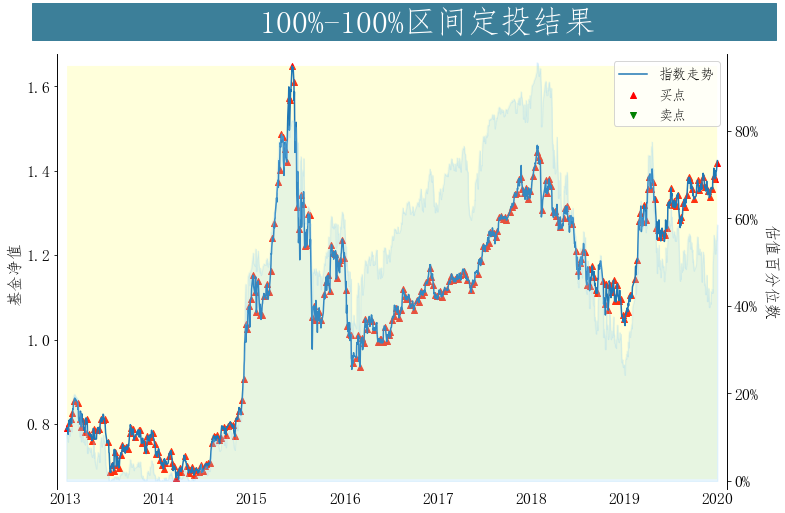

In [273]:
run_strategy(index_code="000300.SH",fund_code="110020.OF",start_date="20130101",end_date="20200101",v_low=100,v_high=100)

## 20%-80%区间

,起始日,截止日,投资期数,单位平均成本,期末单位净值,总收益率
0,2013-01-07,2015-05-25,113,0.810976,1.5714,0.928


年化收益率：9.83%
绝对收益：524320.0


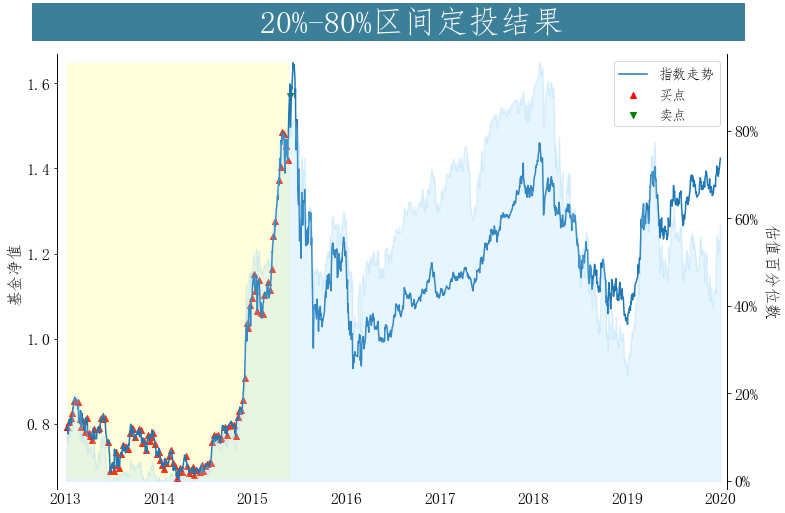

In [261]:
run_strategy(index_code="000300.SH",fund_code="110020.OF",start_date="20130101",end_date="20200101",v_low=20,v_high=80)

## 30%-80%区间

,起始日,截止日,投资期数,单位平均成本,期末单位净值,总收益率
0,2013-01-07,2015-05-25,113,0.810976,1.5714,0.928
1,2018-12-24,2019-12-30,52,1.287953,1.4193,0.102


年化收益率：7.58%
绝对收益：550840.0


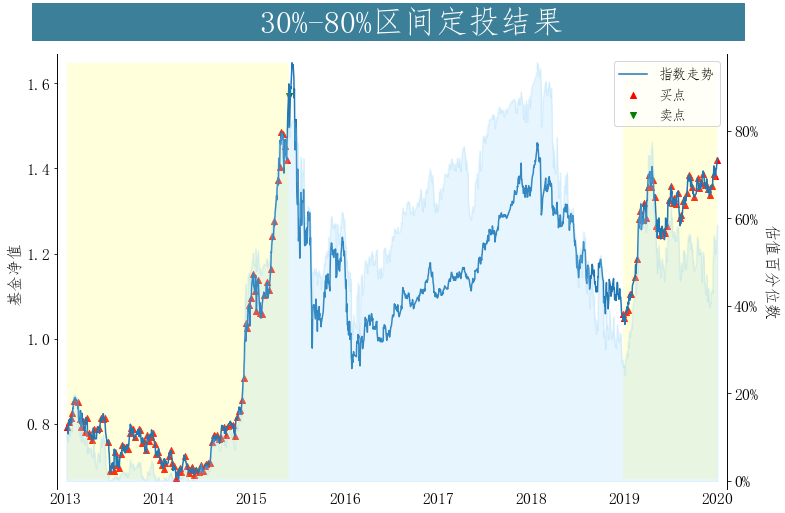

In [285]:
run_strategy(index_code="000300.SH",fund_code="110020.OF",start_date="20130101",end_date="20200101",v_low=30,v_high=80)

## 40%-80%区间

,起始日,截止日,投资期数,单位平均成本,期末单位净值,总收益率
0,2013-01-07,2015-05-25,113,0.810976,1.5714,0.9280
1,2015-08-31,2017-07-13,88,1.095201,1.2359,0.1228
2,2018-08-20,2019-12-30,68,1.243970,1.4193,0.1409


年化收益率：5.61%
绝对收益：626258.0


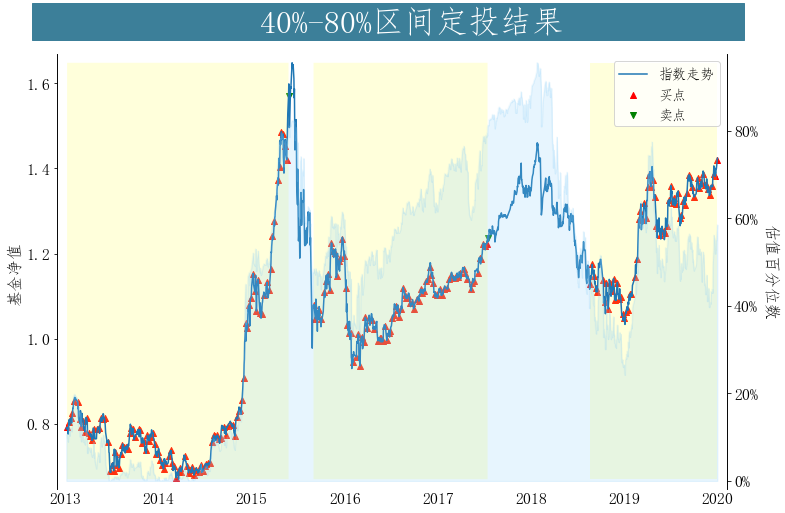

In [287]:
run_strategy(index_code="000300.SH",fund_code="110020.OF",start_date="20130101",end_date="20200101",v_low=40,v_high=80)

## 30%-70%区间

,起始日,截止日,投资期数,单位平均成本,期末单位净值,总收益率
0,2013-01-07,2015-04-13,107,0.791639,1.3726,0.7252
1,2018-12-24,2019-04-03,14,1.177176,1.3721,0.1598


年化收益率：7.51%
绝对收益：399167.99999999994


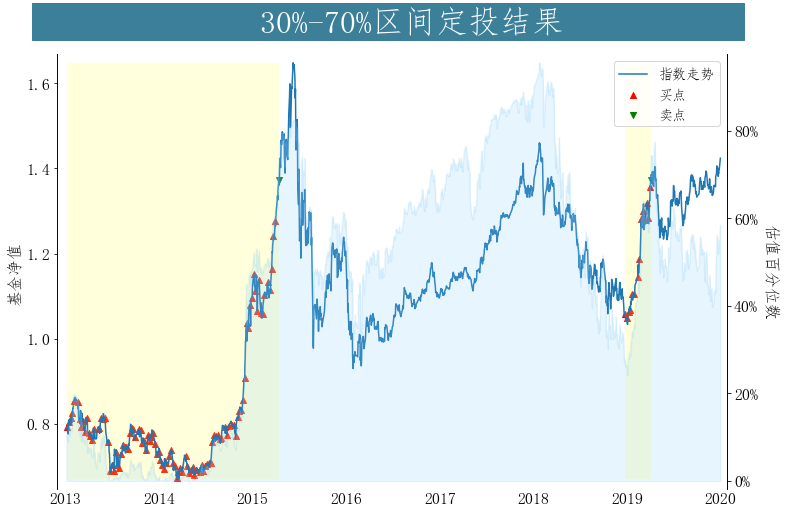

In [288]:
run_strategy(index_code="000300.SH",fund_code="110020.OF",start_date="20130101",end_date="20200101",v_low=30,v_high=70)

## 40%-70%区间

,起始日,截止日,投资期数,单位平均成本,期末单位净值,总收益率
0,2013-01-07,2015-04-13,107,0.791639,1.3726,0.7252
1,2015-08-31,2016-11-28,60,1.071548,1.1687,0.0852
2,2018-08-20,2019-04-03,30,1.145808,1.3721,0.1915
3,2019-12-02,2019-12-30,5,1.378601,1.4193,0.0295


年化收益率：5.33%
绝对收益：443004.4999999999


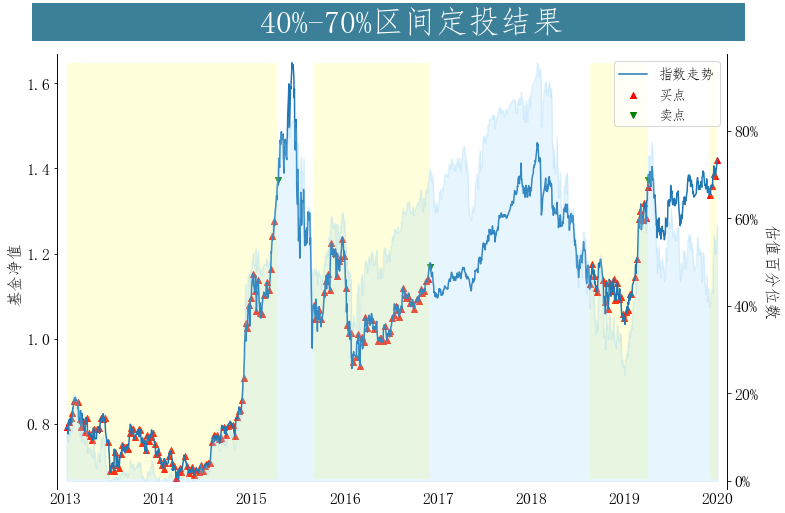

In [289]:
run_strategy(index_code="000300.SH",fund_code="110020.OF",start_date="20130101",end_date="20200101",v_low=40,v_high=70)

## 20%-70%区间

,起始日,截止日,投资期数,单位平均成本,期末单位净值,总收益率
0,2013-01-07,2015-04-13,107,0.791639,1.3726,0.7252


年化收益率：8.10%
绝对收益：387981.99999999994


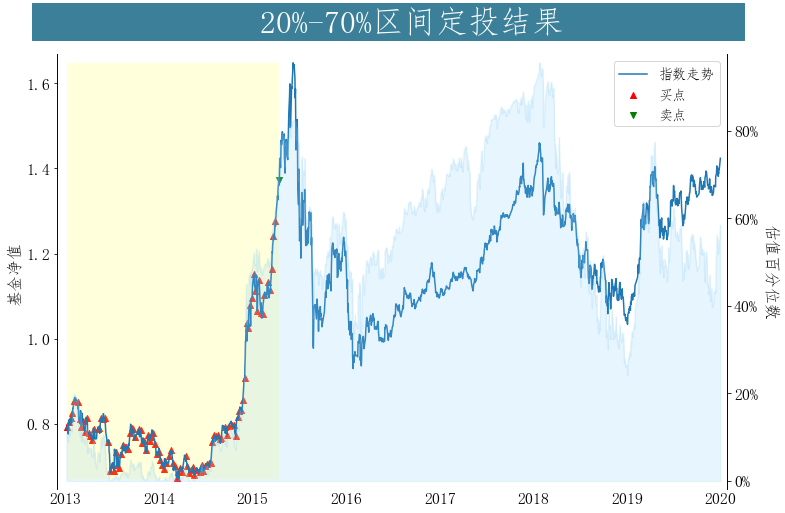

In [290]:
run_strategy(index_code="000300.SH",fund_code="110020.OF",start_date="20130101",end_date="20200101",v_low=20,v_high=70)

## 结果汇总

In [311]:
result_list = []
for v_low in [20,30,40]:
    for v_high in [70,80]:
        result_list.append(get_result(index_code="000300.SH",fund_code="110020.OF",start_date="20130101",end_date="20200101",v_low=v_low,v_high=v_high))

,起始日,截止日,投资期数,单位平均成本,期末单位净值,总收益率
0,2013-01-07,2015-04-13,107,0.791639,1.3726,0.7252


年化收益率：108.10%
绝对收益：387981.99999999994


,起始日,截止日,投资期数,单位平均成本,期末单位净值,总收益率
0,2013-01-07,2015-05-25,113,0.810976,1.5714,0.928


年化收益率：109.83%
绝对收益：524320.0


,起始日,截止日,投资期数,单位平均成本,期末单位净值,总收益率
0,2013-01-07,2015-04-13,107,0.791639,1.3726,0.7252
1,2018-12-24,2019-04-03,14,1.177176,1.3721,0.1598


年化收益率：108.29%
绝对收益：399167.99999999994


,起始日,截止日,投资期数,单位平均成本,期末单位净值,总收益率
0,2013-01-07,2015-05-25,113,0.810976,1.5714,0.928
1,2018-12-24,2019-12-30,52,1.287953,1.4193,0.102


年化收益率：110.21%
绝对收益：550840.0


,起始日,截止日,投资期数,单位平均成本,期末单位净值,总收益率
0,2013-01-07,2015-04-13,107,0.791639,1.3726,0.7252
1,2015-08-31,2016-11-28,60,1.071548,1.1687,0.0852
2,2018-08-20,2019-04-03,30,1.145808,1.3721,0.1915
3,2019-12-02,2019-12-30,5,1.378601,1.4193,0.0295


年化收益率：109.00%
绝对收益：443004.4999999999


,起始日,截止日,投资期数,单位平均成本,期末单位净值,总收益率
0,2013-01-07,2015-05-25,113,0.810976,1.5714,0.9280
1,2015-08-31,2017-07-13,88,1.095201,1.2359,0.1228
2,2018-08-20,2019-12-30,68,1.243970,1.4193,0.1409


年化收益率：111.24%
绝对收益：626258.0


In [312]:
result_list.append(['不择时',334,629757.0,1.0468])

In [313]:
final_df = pd.DataFrame(result_list,columns=["估值区间","总定投期数","期间绝对收益","年化"])

In [314]:
final_df["绝对收益比"] = np.round(final_df["期间绝对收益"]/629757,2)
final_df["年化"] = (np.round((final_df["年化"]-1)*100,2)).map(lambda x:"{}%".format(x))

In [317]:
final_df.sort_values(by="总定投期数",ascending=False)

,估值区间,总定投期数,期间绝对收益,年化,绝对收益比
6,不择时,334,629757.0,4.68%,1.00
5,40%-80%区间,269,626258.0,11.24%,0.99
4,40%-70%区间,202,443004.5,9.0%,0.70
3,30%-80%区间,165,550840.0,10.21%,0.87
2,30%-70%区间,121,399168.0,8.29%,0.63
1,20%-80%区间,113,524320.0,9.83%,0.83
0,20%-70%区间,107,387982.0,8.1%,0.62


![](https://upload-images.jianshu.io/upload_images/8316927-33a33e5473ec8358.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)